##### Load dependencies

In [44]:
from cil.framework import AcquisitionData, DataContainer
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import RingRemover, Padder, Slicer, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP

import hdf5plugin
import algotom.prep.removal as rem
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


In [45]:
from scripts.HDF5_ParallelDataReader import HDF5_ParallelDataReader
from scripts.Normaliser import Normaliser
from scripts.WeightDuplicateAngles import WeightDuplicateAngles

##### Load the data

Specify the parent directory and list the scans

In [46]:
# specify the parent directory
parent_directory = '/mnt/data/ESRF/test_data/'

# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.h5'))
for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))


0: /mnt/data/ESRF/test_data/PC811_1000cycles_absct_final_0001.h5


choose the number of the file in the files list 

In [47]:

filename = files[0]


or uncomment below to specify the filename directly

In [48]:
# filename = '/mnt/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'

Print the metadata to find the locations of data and scan information

In [49]:
HDF5_utilities.print_metadata(filename)

	 - 1.1 : <HDF5 group "/1.1" (6 members)>
		 - end_time : <HDF5 dataset "end_time": shape (), type "|O">
		 - instrument : <HDF5 group "/1.1/instrument" (37 members)>
			 - epoch_trig : <HDF5 group "/1.1/instrument/epoch_trig" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
						 - units : s
			 - fpico2 : <HDF5 group "/1.1/instrument/fpico2" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
			 - fpico3 : <HDF5 group "/1.1/instrument/fpico3" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
			 - fscan_parameters : <HDF5 group "/1.1/instrument/fscan_parameters" (24 members)>
				 - acq_time : <HDF5 dataset "acq_time": shape (), type "<f8">
				 - camera_signal : <HDF5 dataset "camera_signal": shape (), type "|O">
				 - display_flag : <HDF5 dataset "display_flag": shape (), type "|b1">
				 - fast_acc_margin : <HDF5 dataset "fast_acc_margin": shape (), type "<f8">
				 - fast_motor : <HDF5 dataset "fast_m

Read the data
- Create a `HDF5_ParallelDataReader` object 
- Configure the paths to relevant data and metadata in the file
- Read the data

In [50]:
reader = HDF5_ParallelDataReader(filename, 
                                 dataset_path=('1.1/measurement/pcoedgehs/',
                                               '4.1/measurement/pcoedgehs/'),
                                 distance_units='mm', angle_units='degree')

reader.configure_angles(angles_path=('1.1/measurement/hrrz_center',
                        '4.1/measurement/hrrz_center'))

reader.configure_pixel_sizes('1.1/instrument/pcoedgehs/x_pixel_size',
                             '1.1/instrument/pcoedgehs/y_pixel_size', HDF5_units = 'um')

reader.configure_normalisation_data(flatfield_path='2.1/measurement/pcoedgehs/',
                                    darkfield_path='3.1/measurement/pcoedgehs/')

reader.configure_sample_detector_distance(sample_detector_distance=90, HDF5_units='mm')

data = reader.read()

##### Normalise

First normalise by flux
- Specify the location of the beam monitor in the data file
- Normalise using the CIL `Normaliser.flux()` method
- Compare the result to un-normalised data

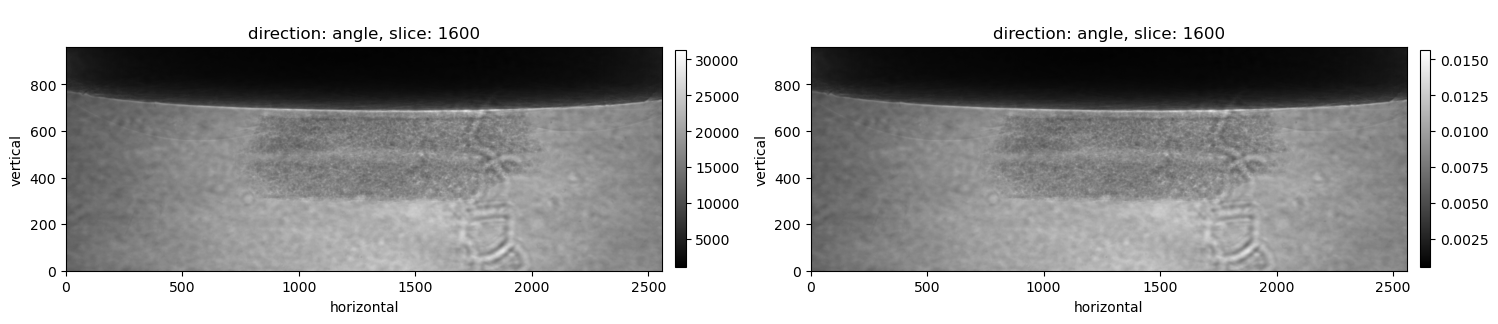

In [51]:
data_before = data.copy()

beam_current = np.concatenate((HDF5_utilities.read(filename, '1.1/instrument/fpico2/data/'),
                HDF5_utilities.read(filename, '4.1/instrument/fpico2/data/')))

processor = Normaliser.flux(flux=beam_current)
processor.set_input(data)
processor.get_output(out=data)

show2D([data_before, data])

Also normalise the flat and dark scans using the same method
- First calculate the number of times the flat field is repeated
- Create an `AcquisitionData` object with the flatfield data in
- Use `HDF5_utilities` to load the beam current from the data file
- Normalise the flat field data using `Normaliser.flux()`

In [52]:
try:
    num_repeats = len(reader.flatfield)
except:
    num_repeats = 1
geom = data.geometry.copy()
geom.set_angles(np.ones(num_repeats))

flatfield = AcquisitionData(reader.flatfield, geometry=geom)
beam_current = HDF5_utilities.read(filename, '2.1/instrument/fpico2/data/')
processor = Normaliser.flux(flux=beam_current)
processor.set_input(flatfield)
processor.get_output(flatfield)

Repeat for darkfield data

In [53]:
try:
    num_repeats = len(reader.darkfield)
except:
    num_repeats = 1
geom = data.geometry.copy()
geom.set_angles(np.ones(num_repeats))
darkfield = AcquisitionData(reader.darkfield, geometry=geom)
beam_current = HDF5_utilities.read(filename, '3.1/instrument/fpico2/data/')
processor = Normaliser.flux(flux=beam_current)
processor.set_input(darkfield)
processor.get_output(darkfield)

Next normalise the data using the flat and dark scans
- Use the CIL `Normaliser.flat_and_dark` method
- Specify the flat and dark scans, averaged along the axis of repeat scans
- Compare the results to un-normalised data

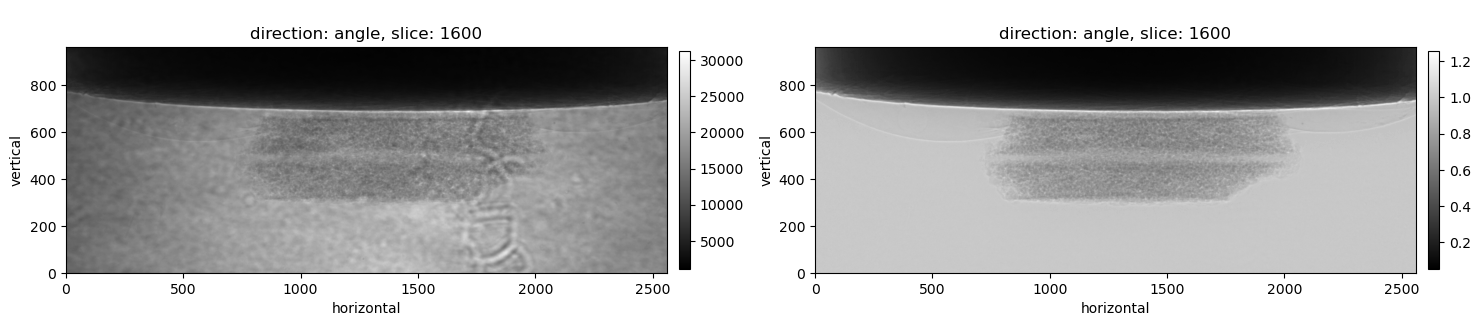

In [54]:
processor = Normaliser.flat_and_dark(flat_field=np.mean(flatfield.array, axis = 0),
                                      dark_field=np.mean(darkfield.array, axis = 0))
processor.set_input(data)
data = processor.get_output()

show2D([data_before, data])

##### Get a vertical slice of the data

In [55]:
vertical_slice = 450
data_slice = data.get_slice(vertical=vertical_slice)


##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter`
- If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

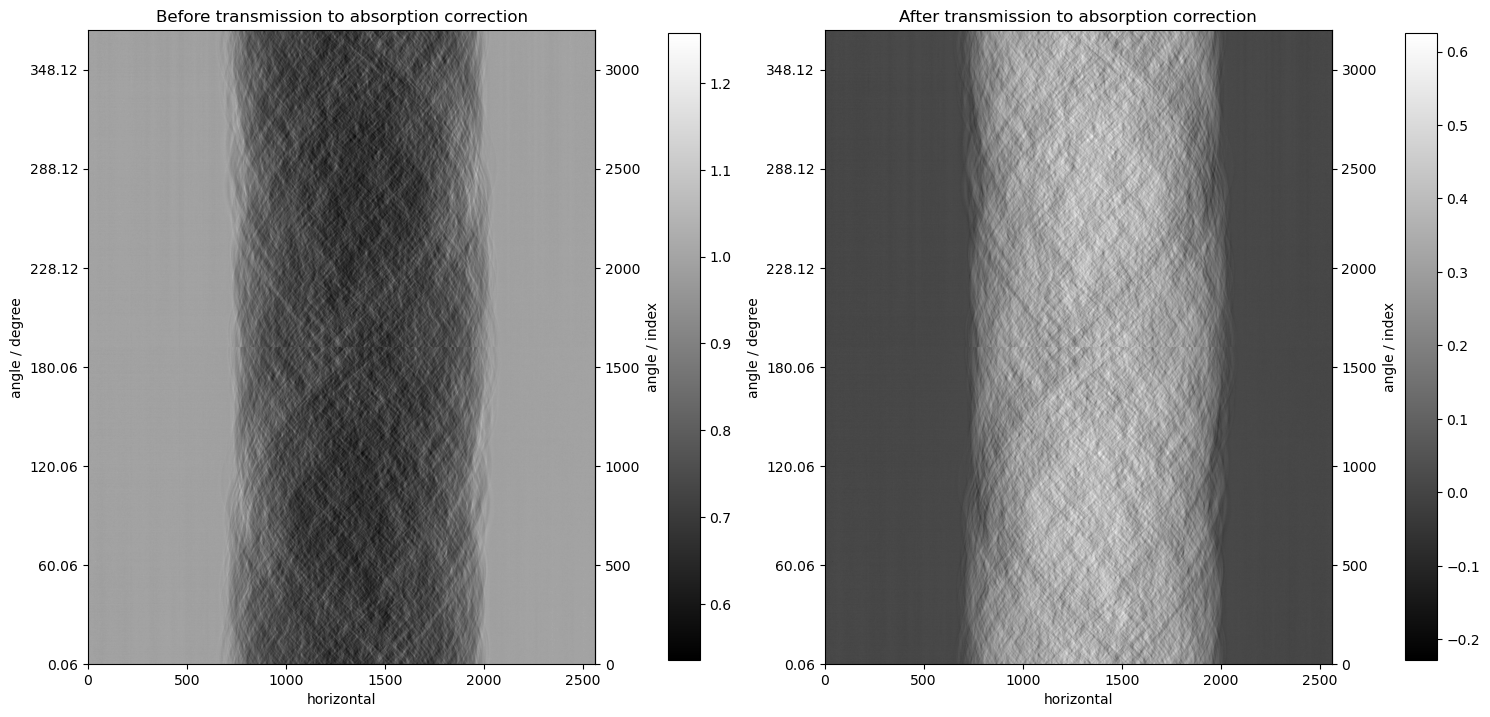

In [56]:
data_before = data_slice.copy()

processor = TransmissionAbsorptionConverter(min_intensity=0.001)
processor.set_input(data_slice)
processor.get_output(out=data_slice)

show2D([data_before, data_slice], 
       ['Before transmission to absorption correction','After transmission to absorption correction'])

reco_before = FBP(data_slice).run(verbose=False)

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, uncomment this cell to use the CIL `CentreOfRotationCorrector.xcorrelation` processor to find the centre of rotation offset automatically
- Specify a first projection to use for the correlation, and the algorithm will identify the second angle which is 180 degrees from the first - within a specified angular tolerance 

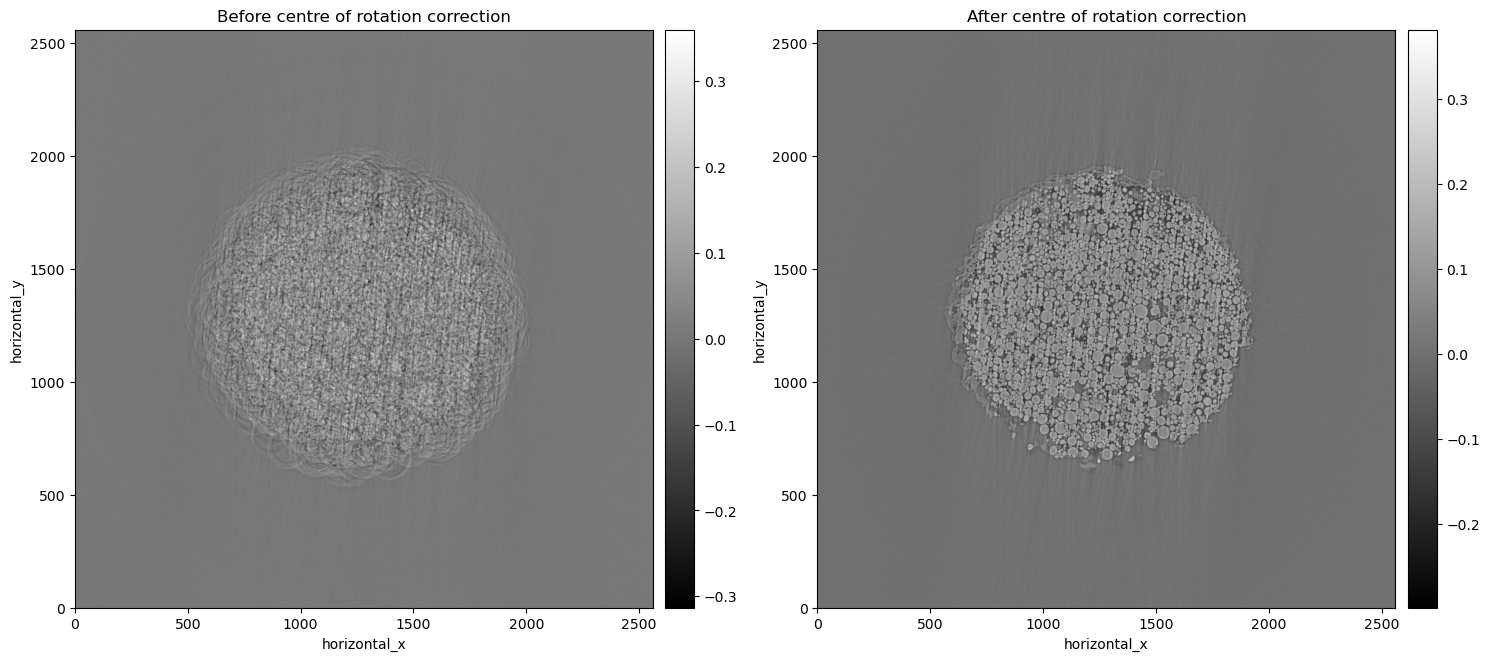

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0.544635, 0.      ]
	Detector position: [ 0., 90.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [2560    1]
	Pixel size: [0.0065 0.0065]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3200
	Angles 0-9 in degrees: [0.05950433, 0.17946315, 0.29948136, 0.41944018, 0.53951776, 0.65947664,
 0.7795542 , 0.89951307, 1.0194719 , 1.1395495 ]
	Angles 3190-3199 in degrees: [370.9201 , 371.0402 , 371.16016, 371.28012, 371.40012, 371.52014,
 371.6401 , 371.7602 , 371.88013, 372.0001 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


In [57]:
data_before = data_slice.copy()
processor = CentreOfRotationCorrector.xcorrelation()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco],
['Before centre of rotation correction','After centre of rotation correction'])

print(data_slice.geometry)

Alternatively manually enter a pixel offset. This could be extracted from the dataset metadata as a starting point

Get the positioner offset, for ID15 this is `hry`


In [58]:


# offset_rotation = HDF5_utilities.read(filename, '/1.1/instrument/positioners/idx')
# offset_rotation = offset_rotation/1000 # convert to m
# print(offset_rotation)

offset = HDF5_utilities.read(filename, '/1.1/instrument/positioners/hry')
offset = offset/1000 # convert to m
print(offset)


[1.4210855e-17 1.4210855e-17 1.4210855e-17 ... 1.4210855e-17 1.4210855e-17
 1.4210855e-17]


Get the pixel size, for ID15 this is `x_pixel_size` OR manually enter a pixel size

In [59]:

# x_pixel_size = HDF5_utilities.read(filename, '/1.1/instrument/pcoedgehs/x_pixel_size')
x_pixel_size = 0.35e-6 # units m
print(x_pixel_size)


3.5e-07


Calculate and apply the pixel offset

In [60]:

pixel_offset = (((offset)/(x_pixel_size)))
print(pixel_offset)

data_slice.geometry.set_centre_of_rotation(np.mean(pixel_offset), distance_units='pixels')

[4.0602445e-11 4.0602445e-11 4.0602445e-11 ... 4.0602445e-11 4.0602445e-11
 4.0602445e-11]


Adjust the offset until the rotation artefacts are minimised

In [61]:
array_list = []
pixel_offsets = [80., 81, 82, 83, 84, 85, 86]
for p in pixel_offsets:
    data_slice = data_before.copy()
    data_slice.geometry.set_centre_of_rotation(p, distance_units='pixels')
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Centre of rotation offset']) + reco.geometry.dimension_labels)
islicer(DC)


In [62]:
best_slice_index = 3
data_slice.geometry.set_centre_of_rotation(pixel_offsets[best_slice_index], distance_units='pixels')

##### Crop the data

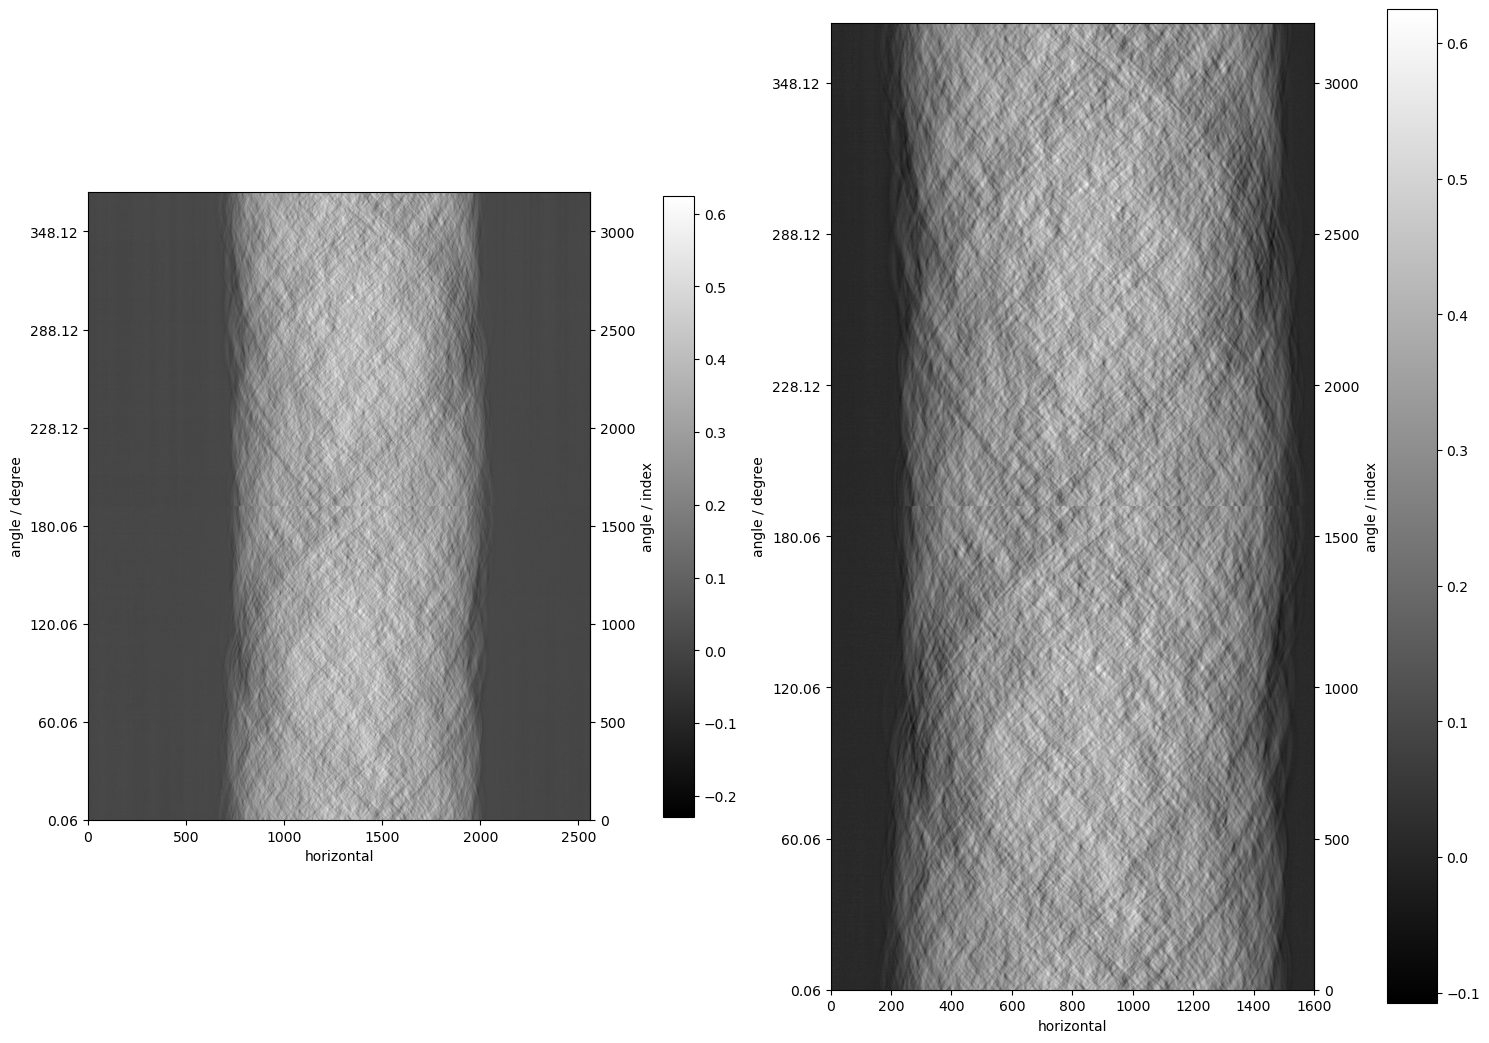

In [63]:
data_before = data_slice.copy()

processor = Slicer(roi = {'horizontal':(500,2100,1)})
processor.set_input(data_slice)
data_slice = processor.get_output()

show2D([data_before, data_slice])


##### Phase retrieval

Get the experiment energy from the data file or for ID19 input the peak energy directly

In [64]:
energy = HDF5_utilities.read(filename, '/1.1/instrument/positioners/llen') 
# energy = 40
print(energy)

40.00003


In [65]:
data_before = data_slice.copy()
reco_before = FBP(data_before).run(verbose=False)
reco_before.apply_circular_mask(0.9)

Run the CIL `PaganinProcessor`
- Input the energy and units
- Increase ratio of `delta/beta` to increase the strength of the filter
- `full_retrieval = False` means the calcultion does not include $-log()$  

100%|██████████| 3200/3200 [00:00<00:00, 7597.29it/s]


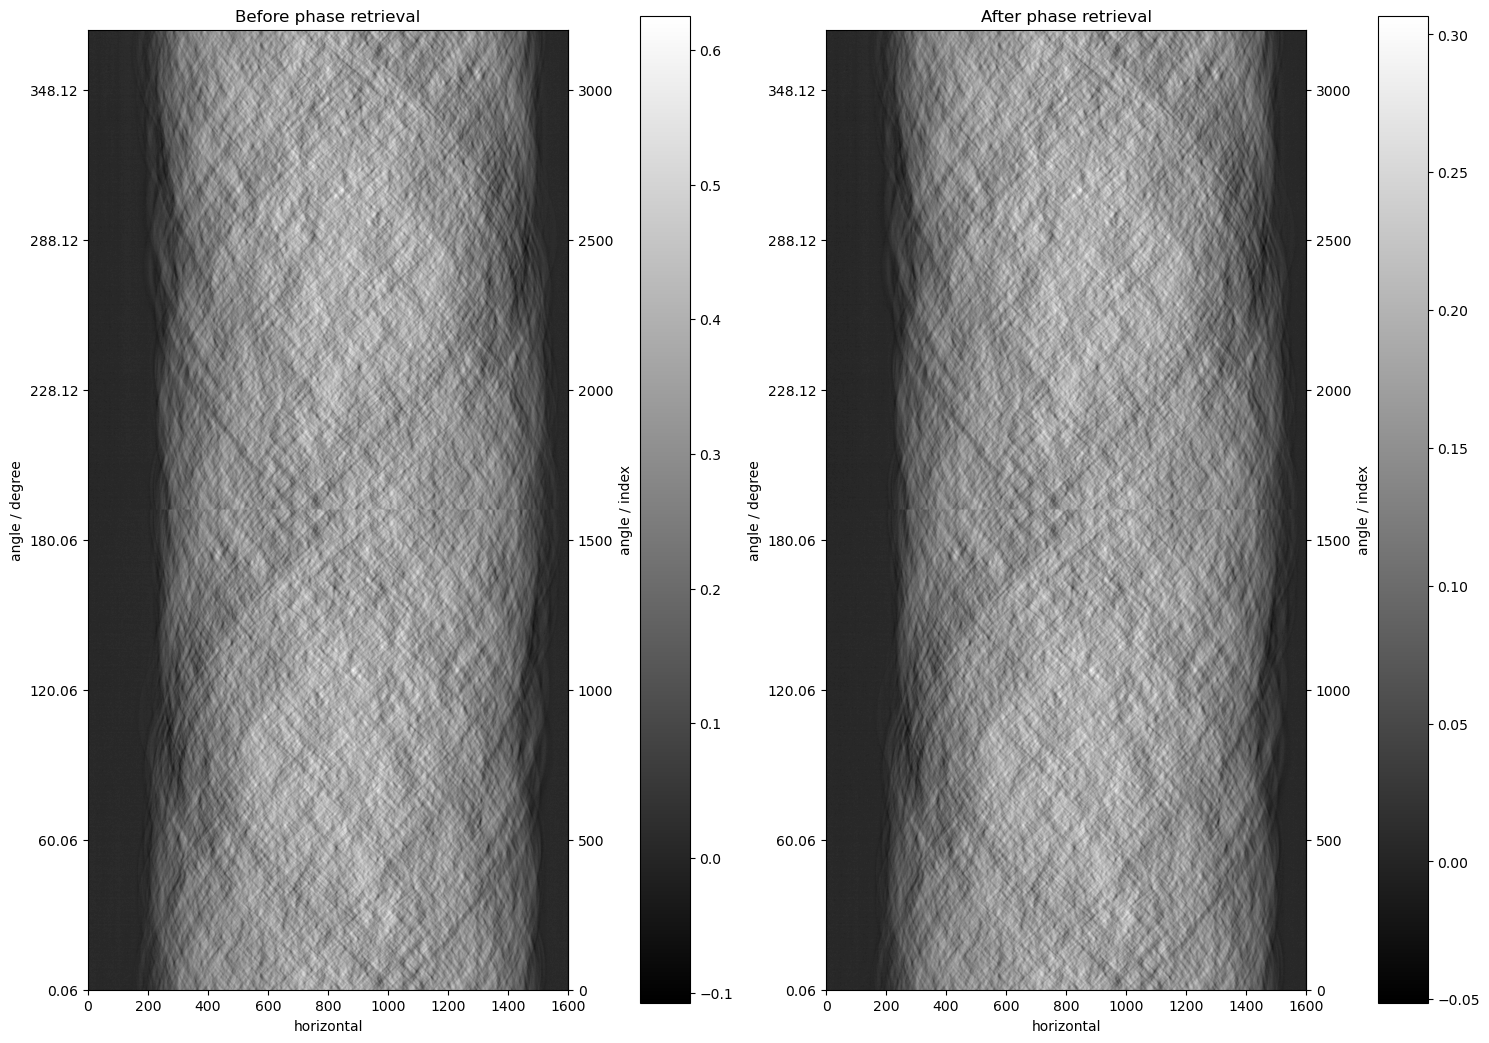

In [66]:
data_slice = data_before.copy()
processor = PaganinProcessor(delta=1, beta=0.05, 
                             energy=40, energy_units='keV', 
                             full_retrieval=False)
processor.set_input(data_slice)
data_slice = processor.get_output()
show2D([data_before, data_slice],
       ['Before phase retrieval','After phase retrieval'])

Compare the reconstruction

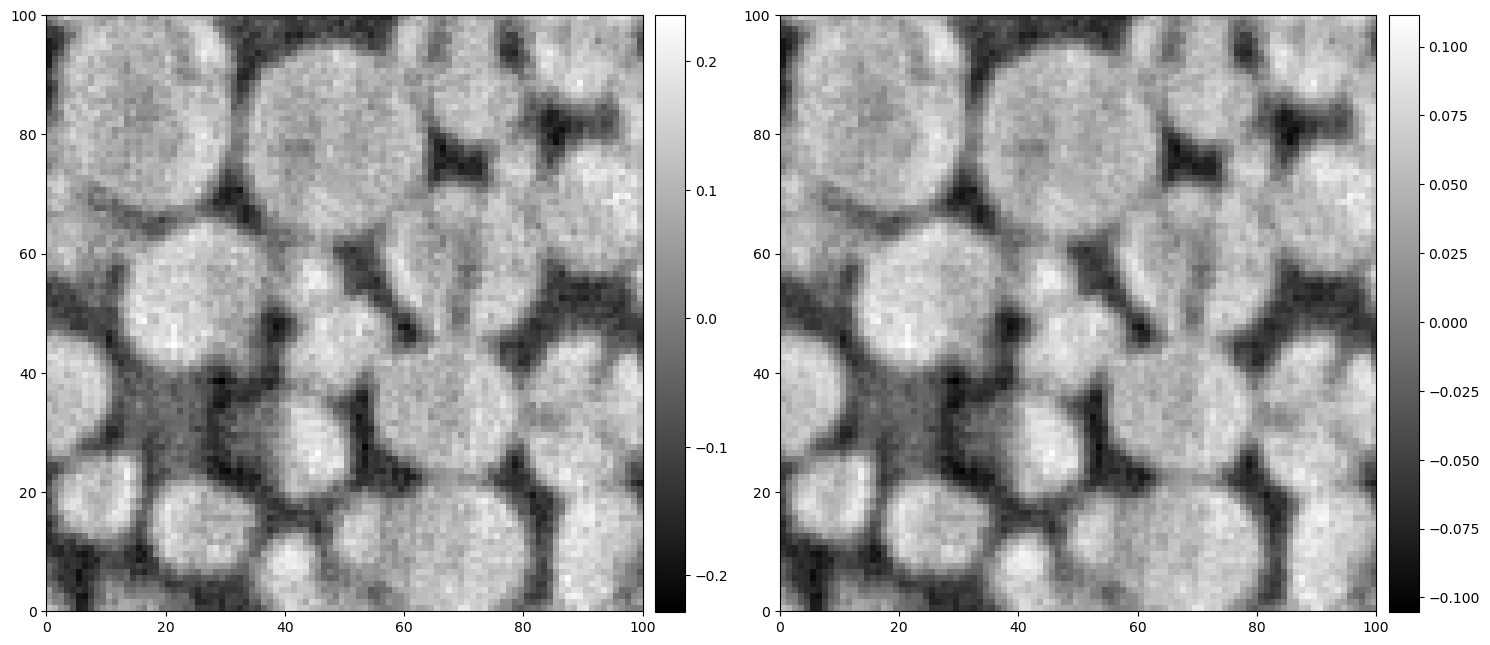

In [67]:
reco = FBP(data_slice).run(verbose=False)
reco.apply_circular_mask(0.9)

show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

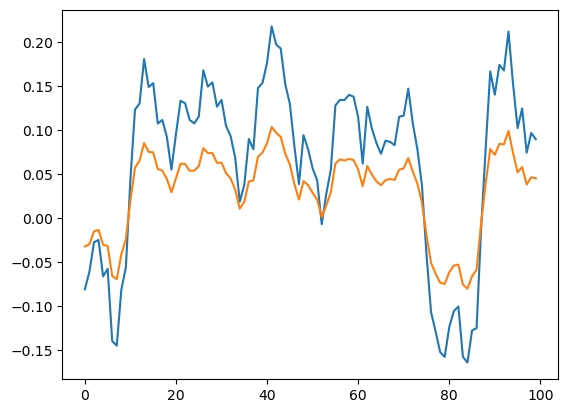

In [68]:
plt.plot(reco_before.array[1100,1100:1200])
plt.plot(reco.array[1100,1100:1200])
plt.xlabel('Horizontal x (pixels)')
plt.ylabel('Intensity')
plt.legend(['Before phase retrieval','After phase retrieval'])

##### Weight duplicate angles

We have some angles with double the data so we see artifacts with FBP reconstruction. We can find the duplicate angles and weight them appropriately for FBP. Using `weight_duplicate_angles` from `weight_duplicate_angles.py`

In [69]:
data_before = data_slice.copy()
reco_before = reco.copy()

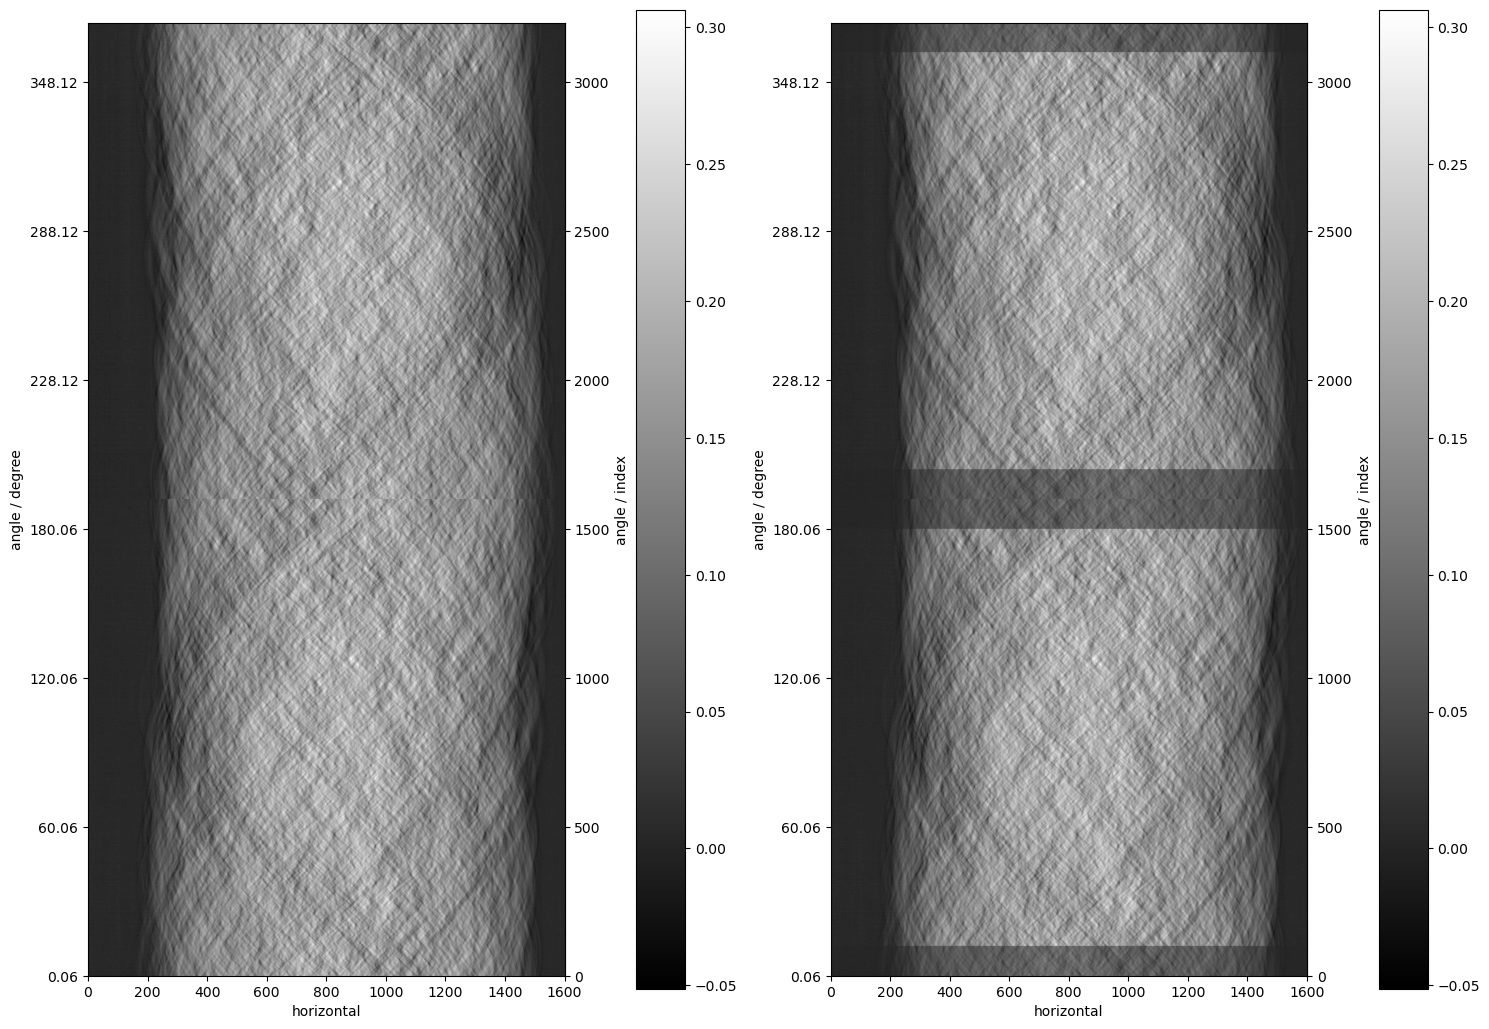

In [70]:
processor = WeightDuplicateAngles()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

show2D([data_before, data_slice])

And now we reconstruct the corrected data

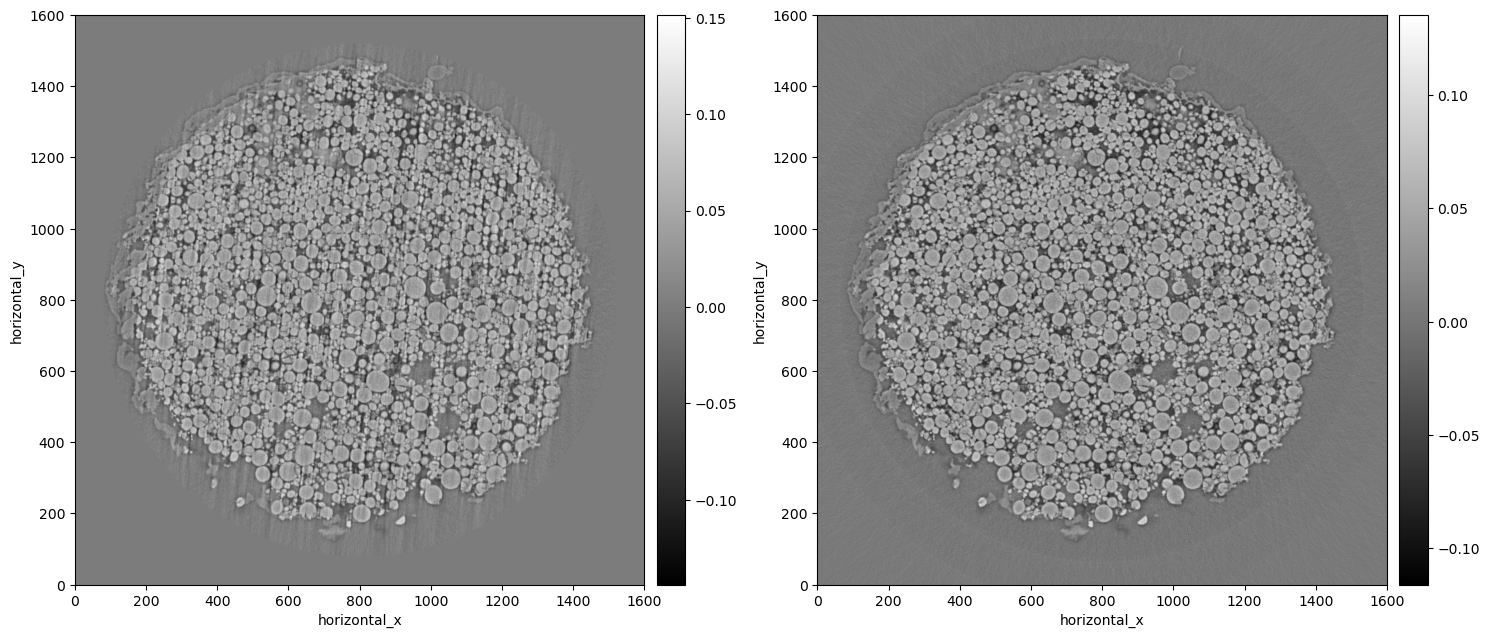

In [71]:
reco = FBP(data_slice).run(verbose=False)

show2D([reco_before, reco])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing sigma increases the frequency of ring artefacts that can be removed
- Increasing the number of decompositions  will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [72]:
data_before = data_slice.copy()
reco_before = reco.copy()

In [73]:
array_list = []
decNum_list = [1, 10, 50, 100, 500]
for d in decNum_list:
    processor = RingRemover(decNum = d, wname = "db35", sigma = 1.5,  info = True)
    processor.set_input(data_before)
    processor.get_output(out=data_slice)
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)
islicer(DC, slice_number=0)


Finish Ring Remover
Finish Ring Remover
Finish Ring Remover
Finish Ring Remover


/home/bgb37495/miniconda3/envs/cil_tests/lib/python3.10/site-packages/cil/processors/RingRemover.py:185: RuntimeWarning: invalid value encountered in multiply
  fCv *= damp.T


Finish Ring Remover


Try the algotom ring remover

In [74]:
array_list = []
snr_list = [1, 2, 3, 10, 50]
for s in snr_list:
    data_slice = rem.remove_all_stripe(data_before.as_array(), s, 5, 1)
    data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover SNR']) + reco.geometry.dimension_labels)
islicer(DC, slice_number=0)

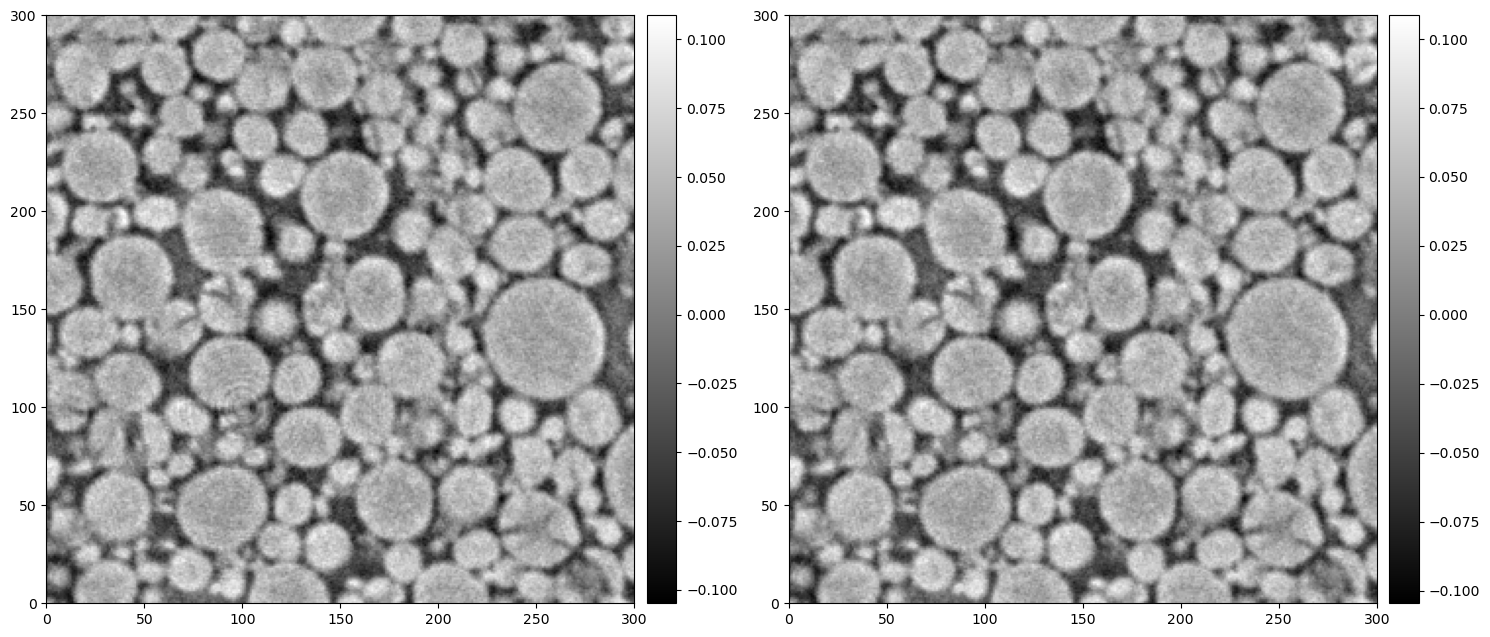

In [75]:
best_snr = 0
data_slice = rem.remove_all_stripe(data_before.as_array(), snr_list[best_snr], 5, 1)
data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[700:1000,700:1000], reco.array[700:1000,700:1000]])

##### Unsharp mask

In [76]:
data_before = data_slice.copy()
reco_before = reco.copy()

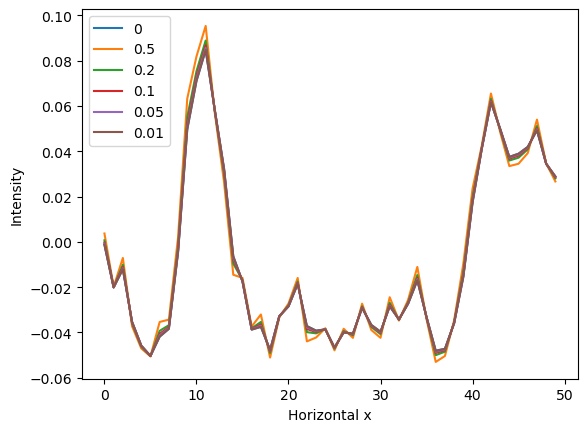

In [77]:
from nabu.processing.unsharp import UnsharpMask

plt.plot(reco_before.array[500,1100:1150])

coeff_list = [0.5, 0.2, 0.1, 0.05, 0.01]
for c in coeff_list:
    mask = UnsharpMask(shape=data_before.shape, sigma=0.1, coeff=c)
    data_slice.fill(mask.unsharp(data_before.array))
    reco = FBP(data_slice).run(verbose=False)
    plt.plot(reco.array[500,1100:1150])

plt.xlabel('Horizontal x')
plt.ylabel('Intensity')
coeff_list.insert(0, 0)
plt.legend(coeff_list)


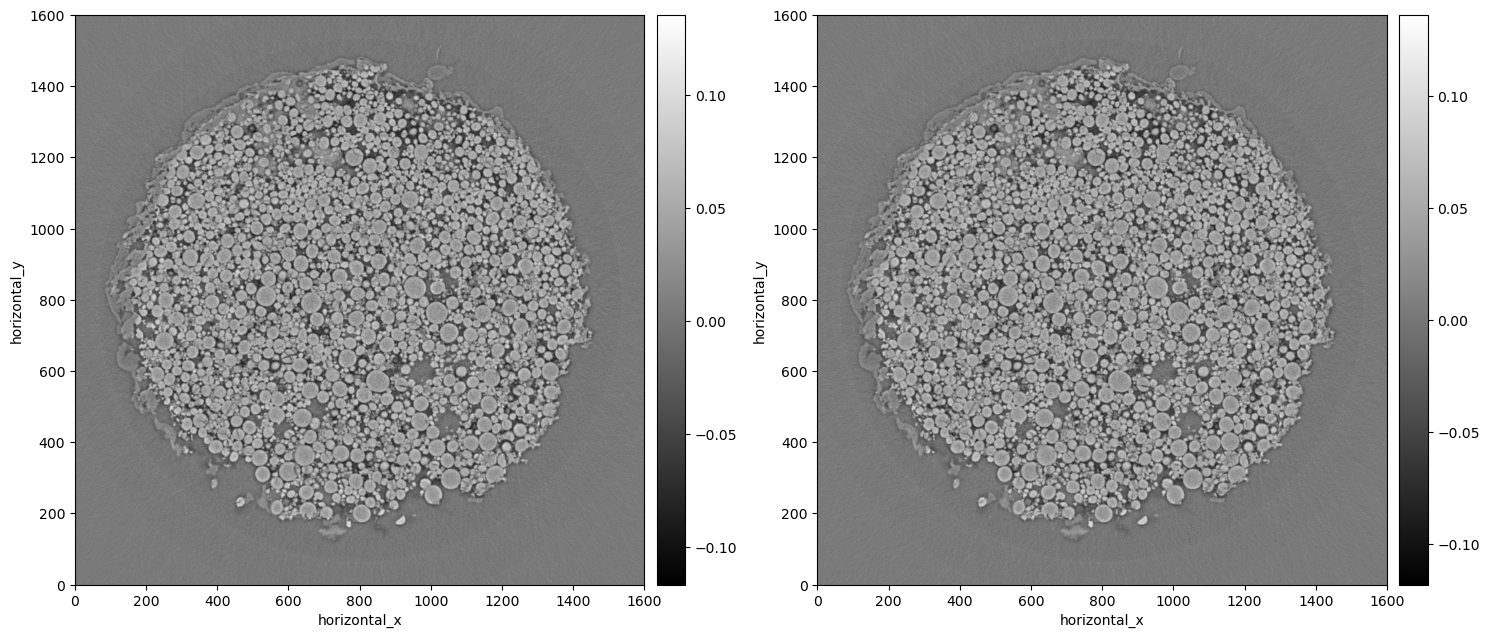

In [78]:
best_coeff = 2
mask = UnsharpMask(shape=data_before.shape, sigma=0.1, coeff=0.1)
data_slice.fill(mask.unsharp(data_before.array))
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco])

##### Save the processed data

Save the processed data as TIFF

In [79]:
writer = TIFFWriter()
writer.set_up(data = data_slice, file_name='path_to_data/data.tiff') #add data type, cast to float16
# writer.write()